In [100]:
%matplotlib notebook

from Libraries.Brett import db, competition
from matplotlib import pyplot
import numpy
from numpy import random
import wfdb
from ipywidgets import interact, IntSlider
import pandas

In [101]:
patients = {int(i.strip()) for i in open(competition.DB_ROOT + 'train.txt').readlines()}
metadata = pandas.read_csv('metadata.csv')
patients = sorted(patients.intersection(metadata['record_id']))
random.seed(7)
patients_sample = random.choice(patients, 100)
metadata.set_index(['record_id', 'segment'], inplace=True)

In [6]:
args = {'part': 'train', 'min_length': 5000}
Y = competition.load_targets(patients_sample, filter_window=None, **args)
Z = competition.load_targets(patients_sample, filter_window=300, **args)

In [7]:
input_sigs = ['PLETH', 'RESP', 'II', 'V', 'AVR']
T_min = 60 * 60 * 10

rec_names = []

for i in range(len(Y)):
    k = sorted(Y)[i]
    hdr = wfdb.rdheader(competition.DB_ROOT + 'train/' + k)
    if all(j in hdr.sig_name for j in input_sigs) and len(Y[k]) > T_min:
        rec_names.append(k)

print(len(rec_names), 'of', len(Y), 'match requirements')

16 of 326 match requirements


<IPython.core.display.Javascript object>


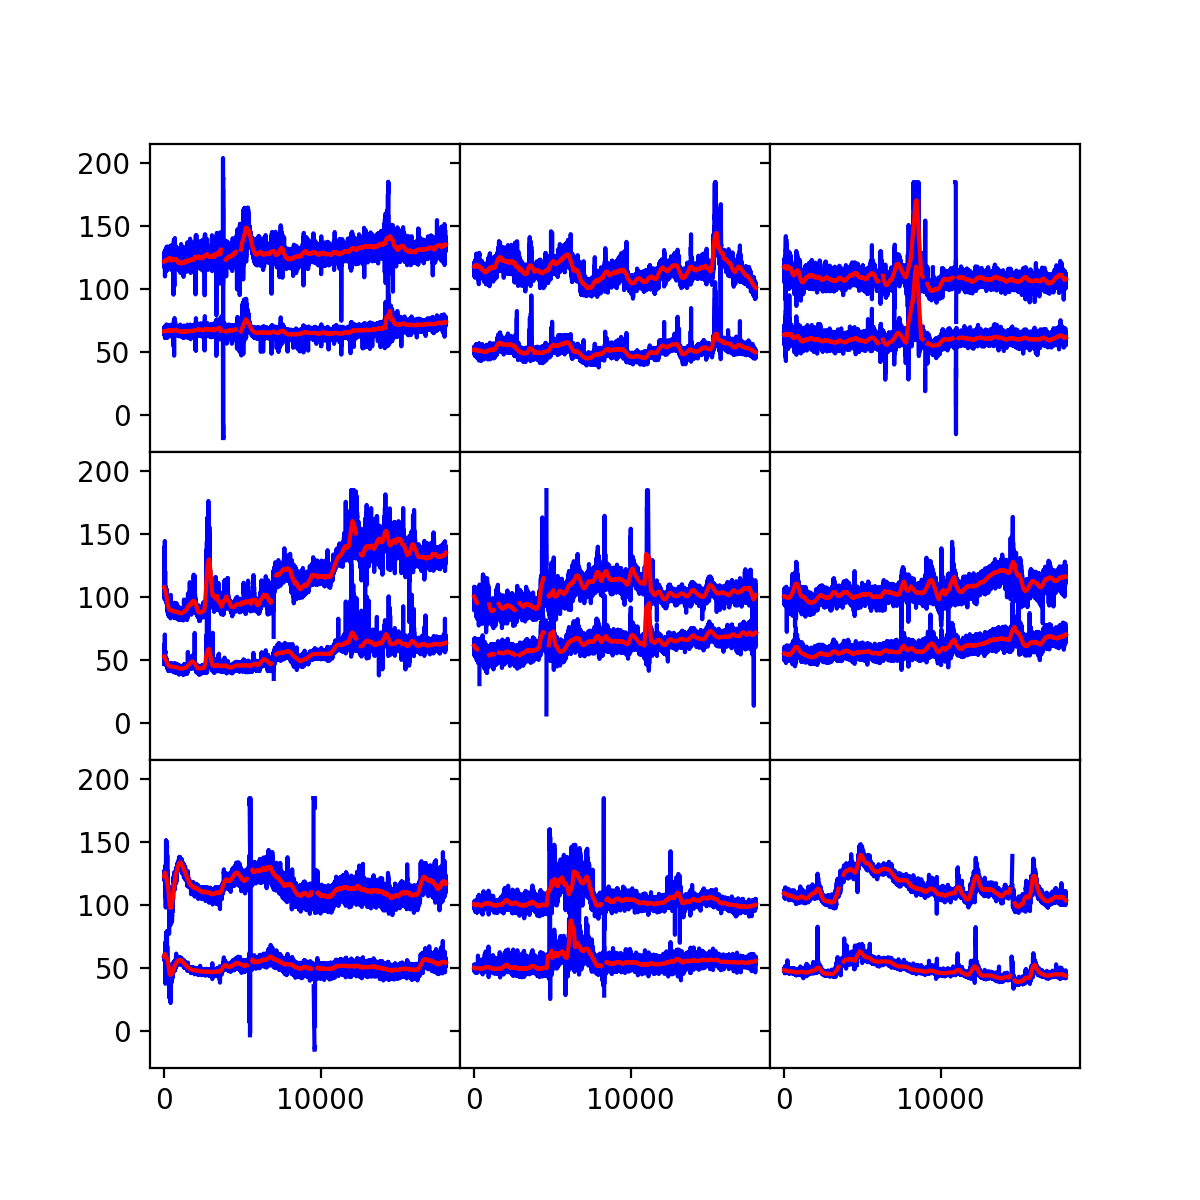

In [9]:
frame = 0
nrows, ncols = 3, 3

fig, ax = pyplot.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(6)
fig.subplots_adjust(wspace=0, hspace=0)

for i, k in enumerate(rec_names[frame*nrows*ncols:(frame+1)*nrows*ncols]):
    rec = db.read_record(competition.DB_ROOT + 'train/' + k)
    t_x = numpy.linspace(0, Y[k].shape[0], num=rec.p_signal.shape[0])    
    ax[i%nrows, i//nrows].plot(Y[k][T_min//2:T_min], 'b')
    ax[i%nrows, i//nrows].plot(Z[k][T_min//2:T_min], 'r')

<IPython.core.display.Javascript object>


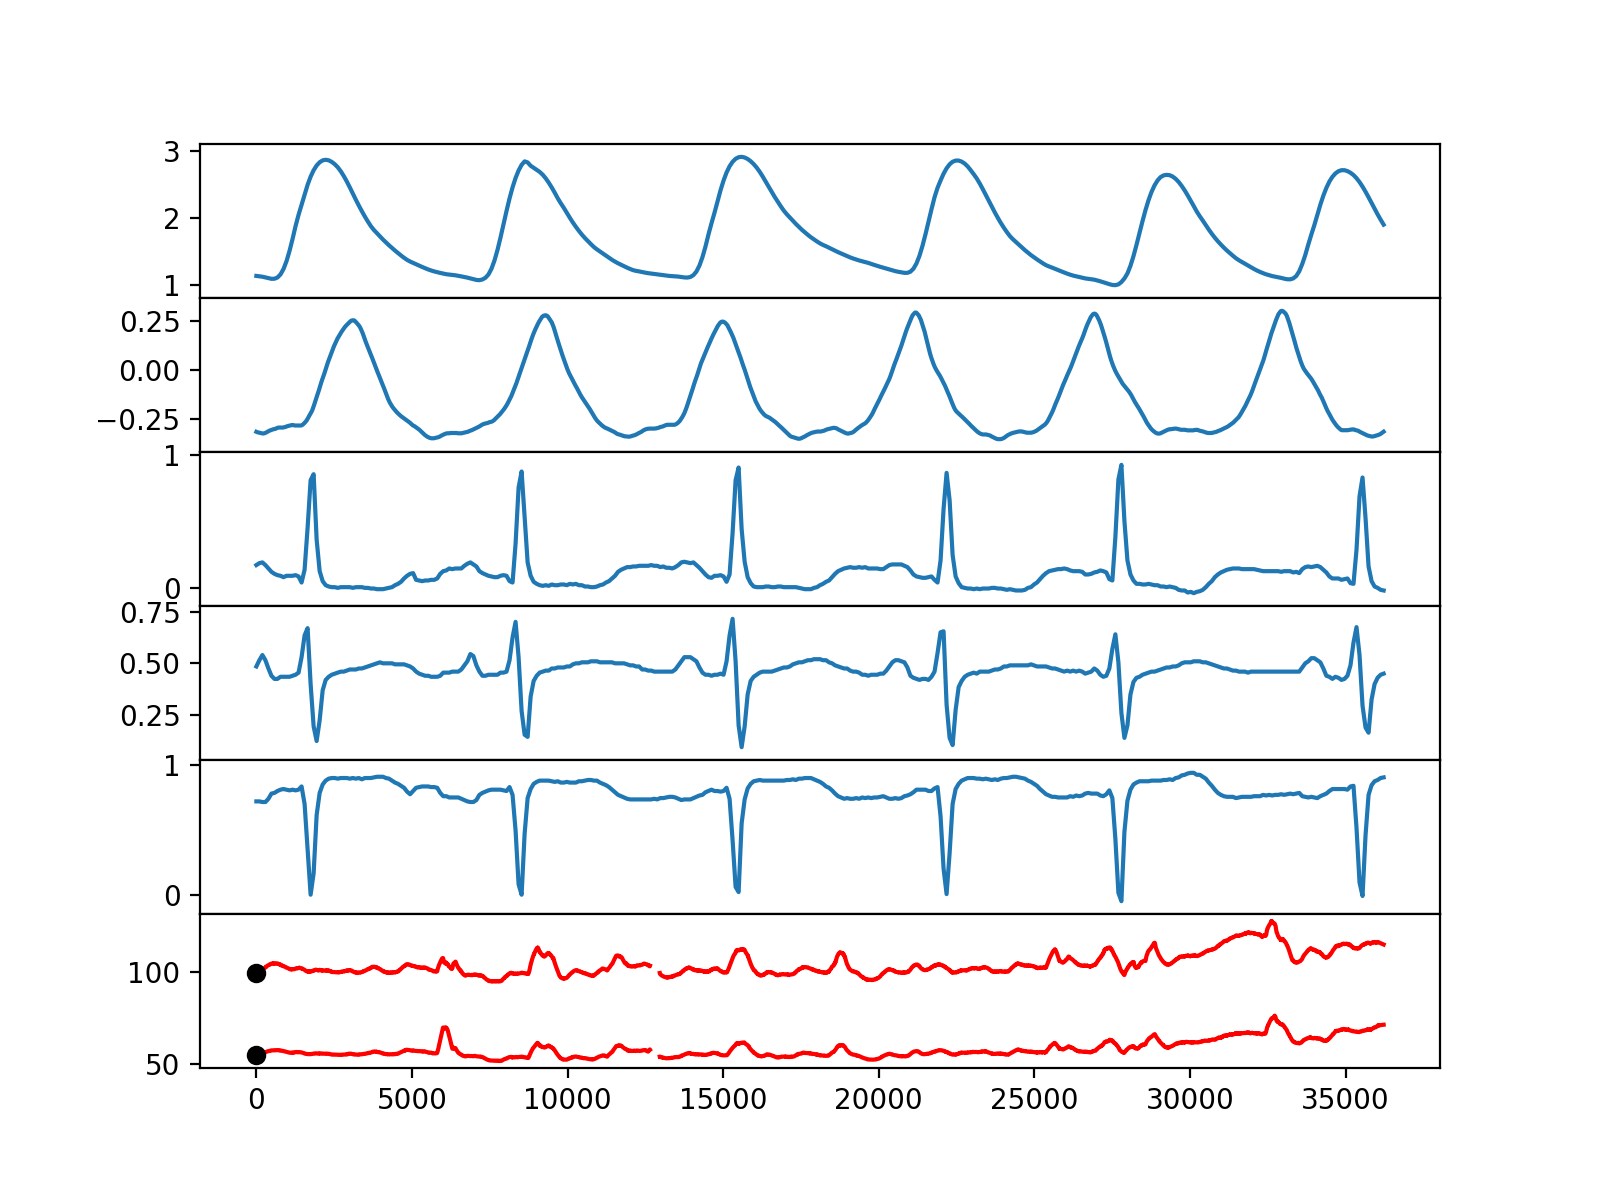

interactive(children=(IntSlider(value=0, description='i', max=36222, step=60), Output()), _dom_classes=('widge…

In [10]:
k = rec_names[7]

t_sig = [3, 15, 3, 3, 3]
fs = 125

rec = db.read_record(competition.DB_ROOT + 'train/' + k)
x = rec.p_signal[:, [rec.sig_name.index(i) for i in input_sigs]]
y, z = Y[k], Z[k]

fig, ax = pyplot.subplots(nrows=len(input_sigs) + 1)
fig.set_figheight(6)
fig.set_figwidth(8)
fig.subplots_adjust(wspace=0, hspace=0)

# abp_noisy = ax[-1].plot(y, 'b')
abp = ax[-1].plot(z, 'r')
selected, = ax[-1].plot(z[0], 'ok')

lines = []
for j, sig_name in enumerate(input_sigs):
    line, = ax[j].plot(x[:fs*t_sig[j], j])
    lines.append(line)

def update(i):
    selected.set_data([i, i], z[i])
    for j, line in enumerate(lines):
        xij = x[fs*i:fs*(i+t_sig[j]), j]
        line.set_ydata(xij)
        low, high = xij[~numpy.isnan(xij)].min(), xij[~numpy.isnan(xij)].clip(0, 300).max()
        dx = high - low
        ax[j].set_ylim(bottom=low-0.1*dx, top=high+0.1*dx)
    fig.canvas.draw()
    display('{} over {}'.format(*numpy.round(z[i]).astype('int')))

interact(update, i=IntSlider(min=0, max=z.shape[0], step=60, value=0));

In [224]:
root = '/scr-ssd/mimic/'
clinic_file = lambda i: root + 'clinic-data/{}.csv'.format(i.upper())
notes = pandas.read_csv(clinic_file('noteevents'), low_memory=False)
metadata = pandas.read_csv('metadata.csv').set_index(['record_id', 'segment'])
metadata['weight'] *= 2.2

In [22]:
i1, i2 = k.split('_')
meta = metadata.loc[int(i1), int(i2)]
print(meta[['gender', 'age', 'weight', 'height']], '\n'*2)
note = notes[notes['HADM_ID'] == meta['hadm_id']]
discharge_summary = note[note['CATEGORY'] == 'Discharge summary']['TEXT'].values[0]
print(discharge_summary)

gender      M
age        55
weight    187
height     71
Name: (3491494, 26), dtype: object 


Admission Date:  [**2169-11-10**]              Discharge Date:   [**2169-12-1**]

Date of Birth:  [**2114-5-9**]             Sex:   M

Service: SURGERY

Allergies:
Indomethacin

Attending:[**First Name3 (LF) 2836**]
Chief Complaint:
hypotension, abdominal pain

Major Surgical or Invasive Procedure:
Pancreatic pseudocyst, jejunostomy, cholecystectomy and
placement of feeding J-tube - [**2169-11-20**].


History of Present Illness:
Patient is a 55 year old male well known to [**Hospital1 18**] who was
recently d/c on [**2169-10-25**] after 1 month stay in hospital for
gallstone pancreatitis complicated by respiratory and renal
failure which ultimately improved with supportive care. He was
discharged to rehab and was recently sent home 3 days ago.
Today, he awoke with a headache and complained of increasing
abdominal pain. He was
seen by a visiting nurse who noted that the patient appeared
sweaty

In [65]:
for i in note['TEXT'].values:
    for j in i.split('\n'):
        if 'pacer' in j or 'pacemaker' in j:
            print(j)

mechansim but maybe ventricular escape beats or possible pacer
You had a pacer wire for a few days and you tolerated the
maybe ventricular escape beats or possible pacer fusion complexes.  Consider


In [71]:
note

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
37203,41563,80142,126608.0,2140-06-20,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2140-6-13**] ...
91954,92600,80142,126608.0,2140-06-14,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: Aortic ...
91955,92601,80142,126608.0,2140-06-20,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: Aortic ...
91956,92602,80142,126608.0,2140-06-16,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: Aortic ...
278389,257032,80142,126608.0,2140-06-20,NaN,NaN,ECG,Report,NaN,NaN,Atrial fibrillation with two wide complex beat...
278390,257033,80142,126608.0,2140-06-18,NaN,NaN,ECG,Report,NaN,NaN,Baseline artifact. Atrial fibrillation with a...
278391,257034,80142,126608.0,2140-06-16,NaN,NaN,ECG,Report,NaN,NaN,Atrial fibrillation with moderate ventricular ...
278392,257035,80142,126608.0,2140-06-17,NaN,NaN,ECG,Report,NaN,NaN,Atrial flutter with moderate ventricular respo...
278393,257036,80142,126608.0,2140-06-15,NaN,NaN,ECG,Report,NaN,NaN,Atrial fibrillation. Consider left ventricula...
278394,257037,80142,126608.0,2140-06-14,NaN,NaN,ECG,Report,NaN,NaN,Atrial fibrillation with ventricular premature...


In [78]:
print(note[note['CATEGORY'] == 'ECG']['TEXT'].values[0])

Atrial fibrillation with two wide complex beats of uncertain mechansim but
maybe ventricular escape beats or possible pacer fusion complexes.  Consider
left ventricular hypertrophy, although it is non-diagnostic.  Delayed R wave
progression with late precordial QRS transition.  Lateral lead ST-T wave
chnages are non-specific but cannot exclude possible left ventricular
hypertrophy or ischemia.  Findings are non-specific.  Clinical correlation is
suggested.  Since the previous tracing or [**2140-6-18**] delayed R wave progression is
less prominent and intermittent wide complex beats are present.




In [228]:
metadata['sig_name'].value_counts()[:20]

('AVR', 'II', 'PLETH', 'RESP', 'V')                         165008
('ABP', 'AVR', 'II', 'PLETH', 'RESP', 'V')                   67609
('ABP', 'AVR', 'CVP', 'II', 'PLETH', 'RESP', 'V')            33033
('II',)                                                      31018
('II', 'MCL')                                                29685
('V',)                                                       27028
('II', 'PLETH')                                              24895
('II', 'V')                                                  24247
('II', 'III', 'PLETH', 'RESP', 'V')                          20031
('AVR', 'II', 'RESP', 'V')                                   18095
('II', 'MCL1')                                               15502
('II', 'PLETH', 'V')                                         14855
('ABP', 'II', 'III', 'PLETH', 'RESP', 'V')                   14675
('ABP', 'II')                                                14438
('ABP', 'II', 'PLETH')                                       1

In [92]:
condition_names = {
    '4019': 'hypertensive',
    '4280': 'congestive_heart_failure',
    '42731': 'atrial_fibrillation',
    '41401': 'coronary_atherosclerosis',
    '2724': 'hyperlipidemia',
}

def to_years(n_samples): 
    return numpy.around(n_samples / (125 * 3600 * 24 * 365), 1)

def generate_ablative_summary(sigs):
    summary = []
    with_sigs = metadata.copy()
    for i in range(len(sigs) + 1):
        has_condition = with_sigs[condition_names.values()].any(axis=1)
        summary += [{
            'sigs': tuple(sigs[:i]),
            'all_there': with_sigs.shape[0],
            'with_condition': has_condition.sum(),
            'years_total': to_years(with_sigs['sig_len'].sum()),
            'years_with_condition': to_years(with_sigs[has_condition]['sig_len'].sum()),
        }]
        if i < len(sigs): 
            with_sigs = with_sigs[with_sigs['sig_name'].apply(lambda j: sigs[i] in j)]
    return pandas.DataFrame(summary)

In [93]:
generate_ablative_summary(['II', 'V', 'RESP', 'PLETH', 'AVR', 'ABP', 'CVP'])

,sigs,all_there,with_condition,years_total,years_with_condition
0,(),870272,588061,113.7,70.1
1,"(II,)",757858,526289,106.7,65.9
2,"(II, V)",563121,410625,64.4,43.6
3,"(II, V, RESP)",475478,352870,45.7,33.3
4,"(II, V, RESP, PLETH)",422722,311420,39.9,28.3
5,"(II, V, RESP, PLETH, AVR)",340387,253408,32.0,22.4
6,"(II, V, RESP, PLETH, AVR, ABP)",133236,98945,12.1,8.5
7,"(II, V, RESP, PLETH, AVR, ABP, CVP)",51173,36244,4.7,3.2


In [94]:
generate_ablative_summary(['II', 'V', 'PLETH', 'RESP', 'AVR', 'ABP', 'CVP'])

,sigs,all_there,with_condition,years_total,years_with_condition
0,(),870272,588061,113.7,70.1
1,"(II,)",757858,526289,106.7,65.9
2,"(II, V)",563121,410625,64.4,43.6
3,"(II, V, PLETH)",448603,324779,47.5,31.6
4,"(II, V, PLETH, RESP)",422722,311420,39.9,28.3
5,"(II, V, PLETH, RESP, AVR)",340387,253408,32.0,22.4
6,"(II, V, PLETH, RESP, AVR, ABP)",133236,98945,12.1,8.5
7,"(II, V, PLETH, RESP, AVR, ABP, CVP)",51173,36244,4.7,3.2


In [102]:
generate_ablative_summary(['ABP', 'II', 'V', 'PLETH', 'RESP', 'AVR', 'CVP'])

,sigs,all_there,with_condition,years_total,years_with_condition
0,(),870272,588061,113.7,70.1
1,"(ABP,)",292864,205509,44.4,29.5
2,"(ABP, II)",262899,185105,41.3,27.4
3,"(ABP, II, V)",209692,154104,23.5,17.6
4,"(ABP, II, V, PLETH)",178797,130063,16.2,11.4
5,"(ABP, II, V, PLETH, RESP)",172639,125459,15.2,10.8
6,"(ABP, II, V, PLETH, RESP, AVR)",133236,98945,12.1,8.5
7,"(ABP, II, V, PLETH, RESP, AVR, CVP)",51173,36244,4.7,3.2


In [99]:
metadata[['hadm_id', 'subject_id']].notna().all(axis=1).sum()

870272